In [24]:
import os
import imageio
import pygplates
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
from scipy.spatial import cKDTree
from scripts import plotElev as zview
from scripts import mapOutputs as mout
from scripts import refineTime as reftime

# Temporal refinement of goSPL model for bio-like model


Often paleo-elevation reconstruction and associated plate model are provided for coarse time intervals (1 to 5 Ma increments). However in some cases, like when one want to run a ecological model, these time steps are too large and it is required to refine the temporal evolution.

+ One solution consists in outputing `goSPL` results at a finer temporal level but this approach (specially if you which to constrain your model over time with available paleo-elevation dataset) will rely on assimilating data at finer temporal scale to limit errors propagation over time.


+ Another consists in running the `goSPL` model at coarse temporal resolution and then interpolate the output to a finer temporal scale using the plate-boundary velocities.


> This notebook provides a method for these 2 solution and allows to build a temporally refined paleo-elevation reconstruction based on a coarser one. 


The method combines plate movements, clustering techniques and incremental interpolations using a backward/forward approach and has been designed to increase the temporal resolution by a factor of 5, _e.g._ from a 5 Ma to a 1 Ma time step. It can easily been modified to increase this factor or could be ran multiple times to reach the desired time interval.


First we initialise the `Python` class and set the required parameters (default here uses a resolution of 0.1 degrees).

The class requires specific names for the topographic and velocity files. 

+ First the velocities are extracted from gPlates at the desired refined time step as `xy` files and should contains longitudes and latitudes in the first 2 columns and the corresponding plate IDs in the last column. The naming convention for these files should be `velXXMa.xy`.

+ The topography are extracted from the `goSPL` simulation as `netcdf` files with the variable `z` corresponding to the elevation and the naming convention is of the form: `XXMa.nc`.

In [ ]:
rtime = reftime.refineTime(rotation='data/PALEOMAP_PlateModel.rot',
                           plate='data/PlateBoundaries.gpml',
                           dem='data/model5Matopo',
                           vel='data/vel1Ma',
                           out='data/refine'
                          )

We will now perform the temporal refinement (this step is pretty long):

In [ ]:
# Define the time array corresponding to the initial outputs 
# you want to refine (here from 100 to 0 Ma at 5 Ma interval)
times = np.arange(100,-5,-5)

# Perform the refinement
rtime.refinePaleoData(times)

This will have created a series of netcdf files containing the evolving elevations with the desired temporal  step.

## Elevation plots

We can save elevation figures from the `netcdf` files for any particular time interval

In [2]:
rotation = 'data/PALEOMAP_PlateModel.rot'
plate = 'data/PlateBoundaries.gpml'
out = 'data/refine'

rotationModel = pygplates.RotationModel(rotation)
topoFeature = pygplates.FeatureCollection(plate)

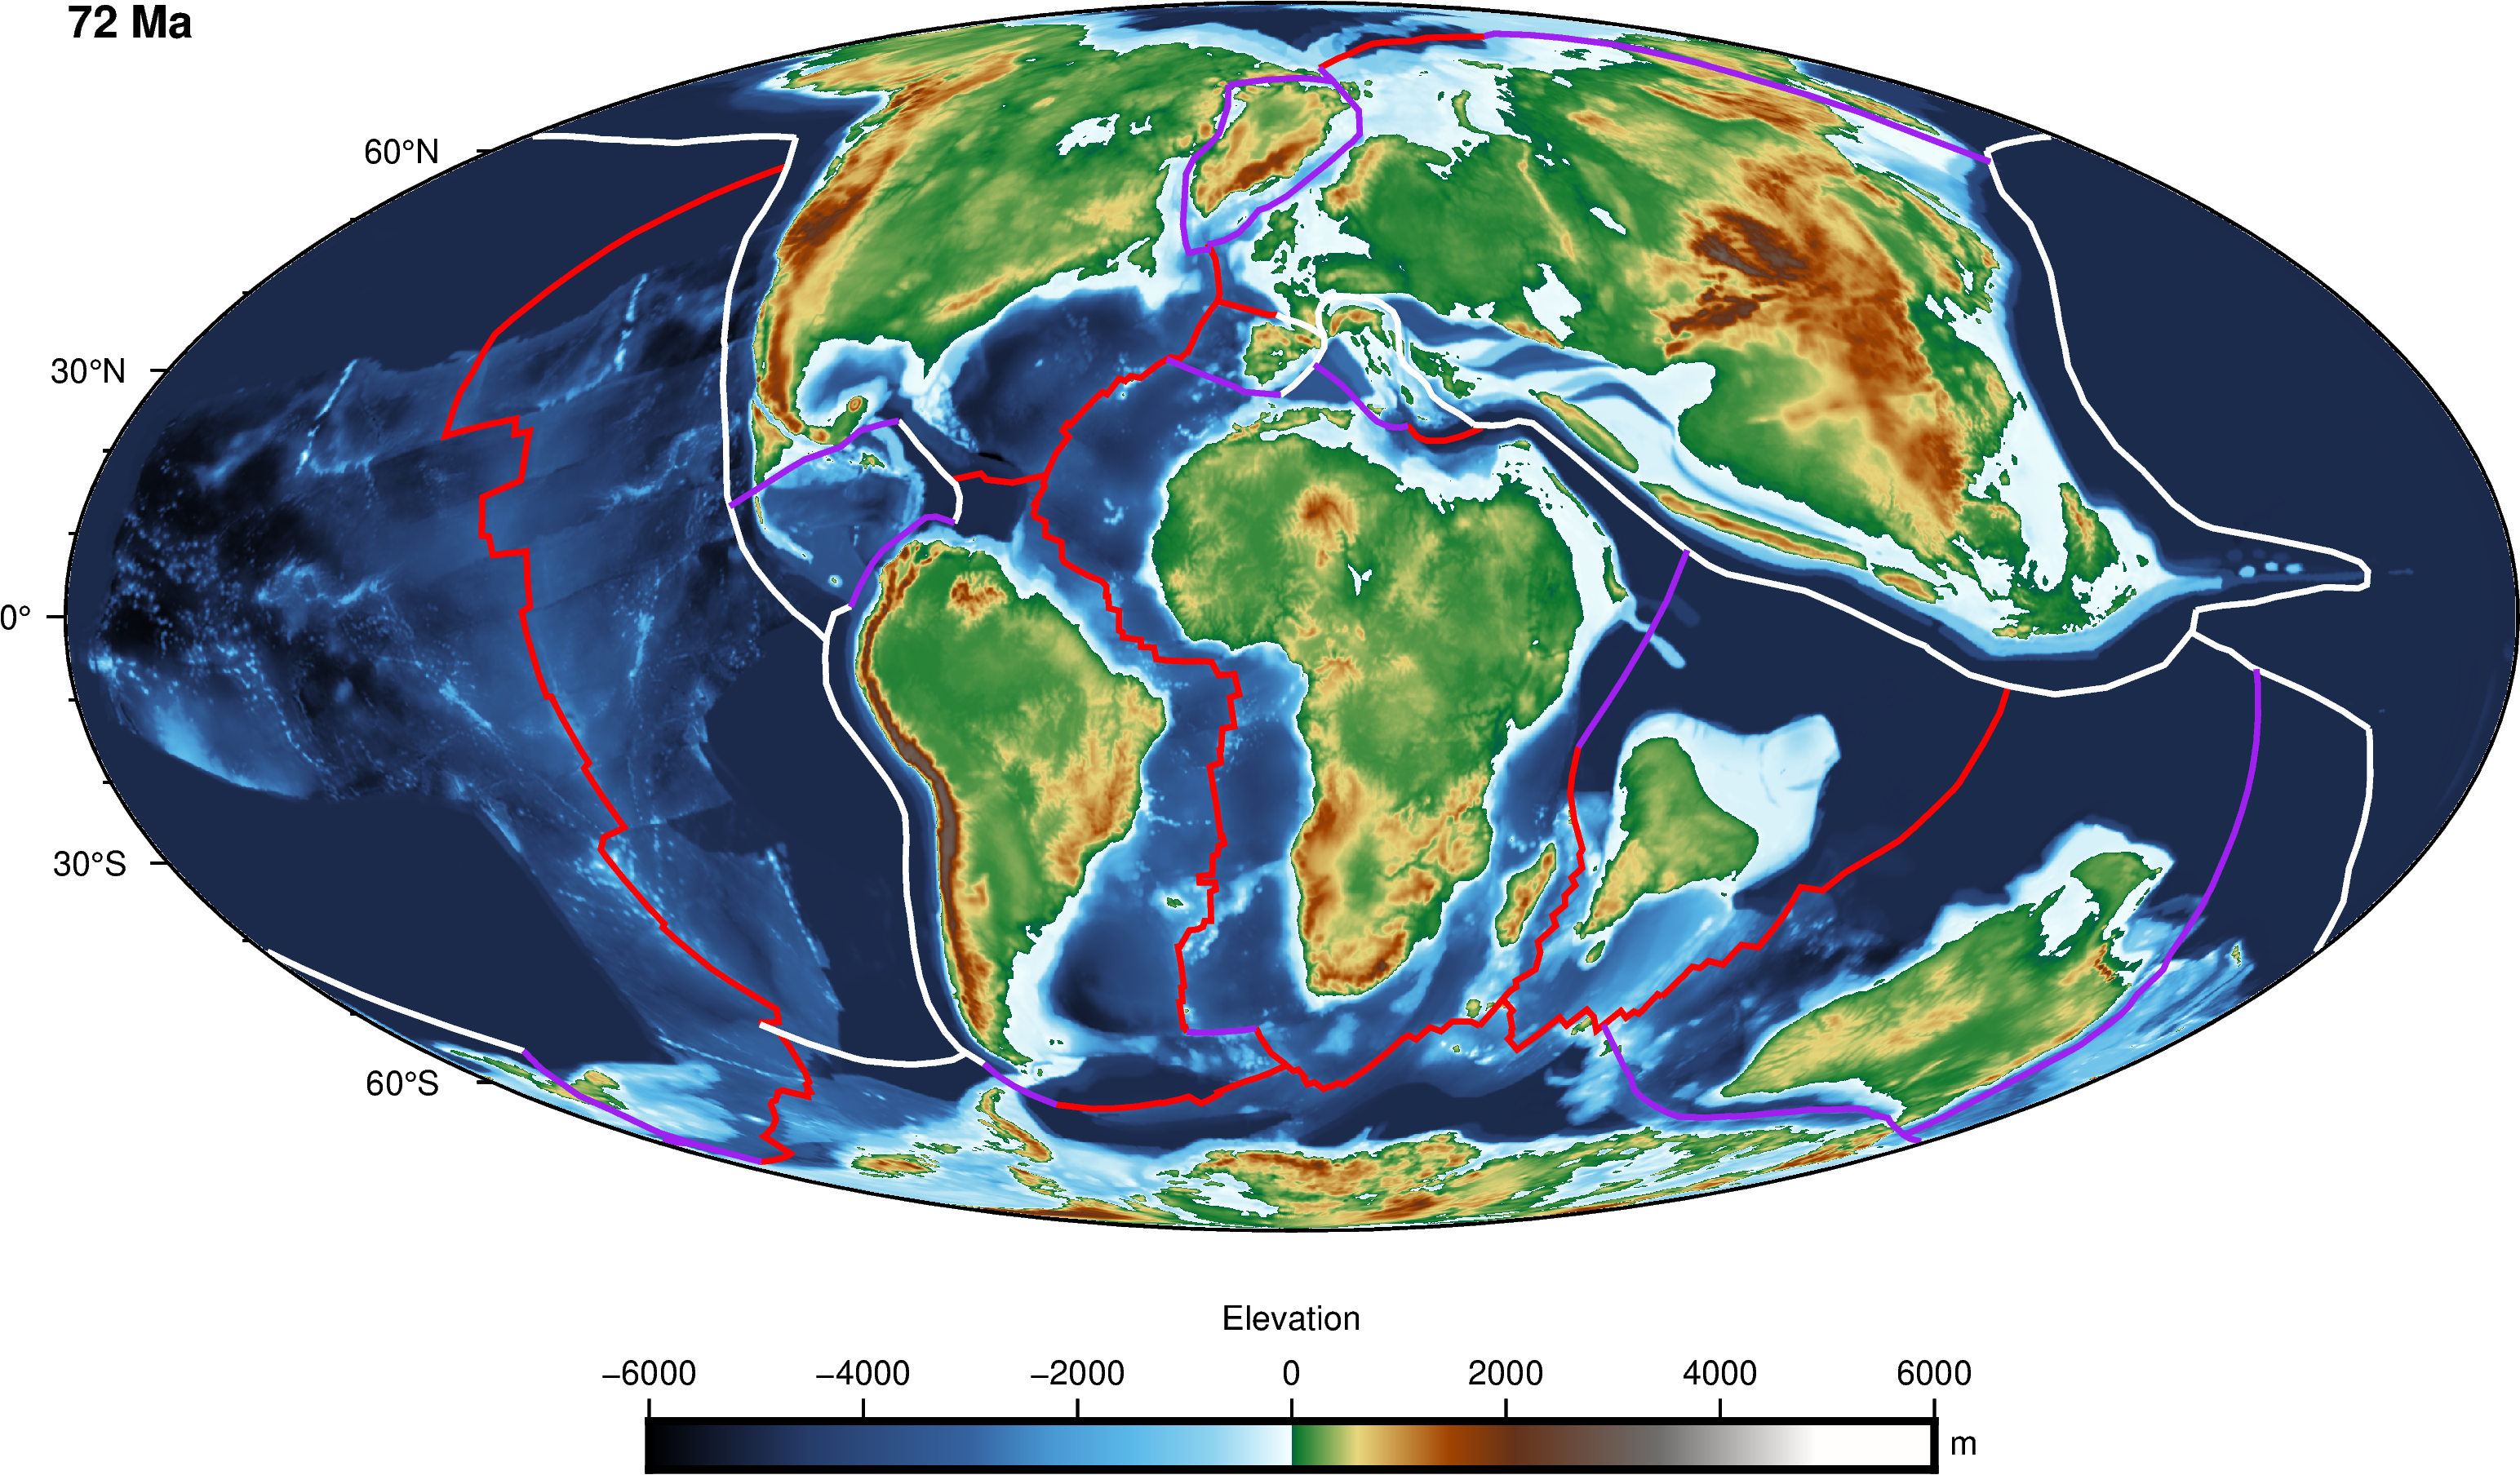

In [6]:
time = 72
zview.viewElev(time, topoFeature, rotationModel, out, show=True)

Or in a loop:

In [ ]:
stime = np.arange(100,-1,-1)

for k in range(len(stime)):
    zview.viewElev(stime[k], topoFeature, rotationModel, out, show=True)

And then create an animated gif out of it:

In [ ]:
images = []
for k in range(len(stime)):
    filename = out+'/elev'+str(int(stime[k]))+'Ma.png'
    images.append(imageio.imread(filename))
                                    
imageio.mimsave('elev1Ma.mp4', images, fps=1)

# Using temporally refined elevation in goSPL

In some cases, you might need in addition to the elevation additional information for your bio/ecological model, such as the river drainage, main stream evolution or the basin indices...

To obtain them at this higher temporal resolution you could rerun a `goSPL` model forced with the elevation you have just calculated where you actually only compute in `goSPL` the flow evolution (thus this is much faster than model where erosion and deposition have also to be accounted for)...

This requires to interpolate the newly temporally refined elevations on the `goSPL` mesh:

In [18]:
def getMeshInfos(meshfile, ncfile):
    
    mdata = np.load(meshfile)
    mCoords = mdata["v"]
    gZ = mdata["z"]
    
    dataset = xr.open_dataset(ncfile)
    glon = dataset.longitude.values
    glat = dataset.latitude.values
    shape = dataset.z.shape
    lons, lats = np.meshgrid(glon, glat)
    
    radius = 6371*1000.
    lonlat = np.empty((len(lons.ravel()),2))
    lonlat[:,0] = lons.ravel()
    lonlat[:,1] = lats.ravel()
    
    # Polar to Cartesian
    theta, phi = np.radians(lonlat[:,0] + 180.0), np.radians(90.0 - lonlat[:,1])
    X = radius * np.cos(theta) * np.sin(phi)
    Y = radius * np.sin(theta) * np.sin(phi)
    Z = radius * np.cos(phi)
    sXYZ = np.stack((X, Y, Z), axis=1)
    
    
    tzer = np.zeros(len(gZ))

    ptree = cKDTree(sXYZ)

    return ptree, mCoords, tzer


def interpMesh(ptree, data, xyz, ngbh=1):
    
    distNbghs, idNbghs = ptree.query(xyz, k=ngbh)
    if ngbh == 1:
        return data[idNbghs]
    
    # Inverse weighting distance...
    weights = np.divide(
        1.0,
        distNbghs,
        out=np.zeros_like(distNbghs),
        where=distNbghs != 0,
    )
    onIDs = np.where(distNbghs[:, 0] == 0)[0]
    temp = np.sum(weights, axis=1)
    tmp = np.sum(weights * data[idNbghs], axis=1)
    # Elevation
    interpZ = np.divide(
        tmp, temp, out=np.zeros_like(temp), where=temp != 0
    )
    if len(onIDs) > 0:
        interpZ[onIDs] = data[idNbghs[onIDs, 0]]
        
    return interpZ

In [20]:
time = 0
meshfile = 'data/mesh_9_100Ma.npz'
ncfile = 'data/ndem1Ma/'+str(time)+'Ma.nc'

outforcing = 'ndata'
if not os.path.exists(outforcing):
    os.makedirs(outforcing)

tree, xyz, tnull = getMeshInfos(meshfile, ncfile)

for t in range(0, 101):
    ncf = 'data/ndem1Ma/'+str(t)+'Ma.nc'
    ds = xr.open_dataset(ncf)
    newH = interpMesh(tree, ds.z.values.ravel(), xyz, ngbh=3)
    np.savez_compressed(outforcing+'/tect'+str(t)+'Ma', z=newH[:], t=tnull)

An example of how to set-up a `YML` input file to run this refined model is provide in the folder (`refined.yml`). This model will be relatively fast so you might want to run it locally on your computer with 6 or 8 cpus.

To generate automatically the inputs in the `YML` file for the `plates` element you can potentially run the command below and copy paste the output in your file: 

In [23]:
time = np.arange(100,-1,-1)

for k in range(len(time)): 
    print('  - start: '+str(-int(time[k]))+'.e6')
    print("    upsub: 'inputs/tecto_8_"+str(time[k])+"Ma'")

  - start: -100.e6
    upsub: 'inputs/tecto_8_100Ma'
  - start: -99.e6
    upsub: 'inputs/tecto_8_99Ma'
  - start: -98.e6
    upsub: 'inputs/tecto_8_98Ma'
  - start: -97.e6
    upsub: 'inputs/tecto_8_97Ma'
  - start: -96.e6
    upsub: 'inputs/tecto_8_96Ma'
  - start: -95.e6
    upsub: 'inputs/tecto_8_95Ma'
  - start: -94.e6
    upsub: 'inputs/tecto_8_94Ma'
  - start: -93.e6
    upsub: 'inputs/tecto_8_93Ma'
  - start: -92.e6
    upsub: 'inputs/tecto_8_92Ma'
  - start: -91.e6
    upsub: 'inputs/tecto_8_91Ma'
  - start: -90.e6
    upsub: 'inputs/tecto_8_90Ma'
  - start: -89.e6
    upsub: 'inputs/tecto_8_89Ma'
  - start: -88.e6
    upsub: 'inputs/tecto_8_88Ma'
  - start: -87.e6
    upsub: 'inputs/tecto_8_87Ma'
  - start: -86.e6
    upsub: 'inputs/tecto_8_86Ma'
  - start: -85.e6
    upsub: 'inputs/tecto_8_85Ma'
  - start: -84.e6
    upsub: 'inputs/tecto_8_84Ma'
  - start: -83.e6
    upsub: 'inputs/tecto_8_83Ma'
  - start: -82.e6
    upsub: 'inputs/tecto_8_82Ma'
  - start: -81.e6
    upsub: 

You can run the model from a jupyter cell:

In [ ]:
#!mpirun -np 8 python3 runModel.py -i refined.yml -v

# Export goSPL outputs for bio models

Then we will be using the `mapOutputs` Python class to first extract the outputs, remap the unstructured variables on a structured mesh (the resolution of this mesh is defined by the `reso` parameter set in degree). The class is also performing additional calculations on the dataset to extract individual catchments based on flow accumulation and elevation.

The interpolated model's variables are then exported as `netCDF` files, and each of them contains the following:

+ elevation `elevation` (m)
+ water flux discharge (accounting for lakes) `fillDischarge`(m3/yr)
+ water flux in rivers (not showing lakes) `flowDischarge` (m3/yr)
+ main basin ids `basinID` (integer)

In [ ]:
# Define output folder name of the simulation
out_path = 'export/refined'

if not os.path.exists(out_path):
    os.makedirs(out_path)

In [ ]:
stp = 1

# Resolution of the netcdf structured grid
reso = 0.1

# Name of each netcdf output file
ncout = os.path.join(out_path, "data")

# Initialisation of the class
grid = mout.mapOutputs(path='./', filename='refined.yml', step=stp, bio=True, uplift=False)

We perform the export using the following loop:

In [ ]:
for k in range(100,-1,-1):
    
    if stp>1:
        # Get goSPL variables
        grid.getData(stp)
        
    # Remap the variables on the regular mesh using distance weighting interpolation
    grid.buildLonLatMesh(res=reso, nghb=3)
    
    # Export corresponding regular mesh variables as netCDF file
    grid.exportNetCDF(ncfile = ncout+str(k)+'Ma.nc', bio=True)
    stp += 1

### Some potential operation you might want to perform on the netcdf

In [ ]:
import rioxarray
from rasterio.enums import Resampling

# specifying the time in Ma you want to downsample (integer)
time = 45 

# Reading the goSPL netcdf file
dataset = rioxarray.open_rasterio('export/refined/data'+str(time)+'Ma.nc')

# Add the coordinate reference system
dataset.rio.write_crs("epsg:4326", inplace=True)

# Resampling by adjusting the factor
factor = 0.1 # this will be 10 time coarser so in this case 1 degree
new_width = int(dataset.rio.width * factor)
new_height = int(dataset.rio.height * factor)

downsampled = dataset.rio.reproject(
    dataset.rio.crs,
    shape=(new_height, new_width),
    resampling=Resampling.bilinear,
)

downsampled.to_netcdf('export/refined/downsample'+str(time)+'.nc')

To reduce the size of the netcdf files you might want to use the following library

In [ ]:
#!pip install elePyant
import elePyant as ep

In [ ]:
time = 68

# Reading the goSPL netcdf file
dataset = rioxarray.open_rasterio('export/refined/data'+str(time)+'Ma.nc')

ep.compress_dataset(dataset, 'export/refined/reduced'+str(time)+'Ma.nc', decimal_places=2)